# Constants

run only once (at starting)

In [ ]:
import tensorflow as tf

tf.random.set_seed(42)

normalize_columns_dict = {
    0: ['MSSubClass', 'LotFrontage', 'LotArea', 'Neighborhood', 'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'MoSold', 'YrSold'],
    0.1: ['LotFrontage', 'LotArea', 'Neighborhood', 'YearBuilt', 'YearRemodAdd', 'Exterior2nd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'],
    0.2: ['LotFrontage', 'LotArea', 'Neighborhood', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'],
    0.3: [
            'LotFrontage', 'YearBuilt', 'YearRemodAdd',
            'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
            'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'
    ],
    0.4: ['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea'],
    0.5: ['YearBuilt', 'YearRemodAdd', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'GarageArea'],
    0.6: ['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']
}

submission_count = 20

max_y = None

# Commons

In [ ]:
def labelize_object_columns(df):
    for col in df.columns.drop("SalePrice", errors="ignore"):
        if df[col].dtype == "object" or (df[col].dtype == "int" and len(df[col].unique()) < 0.05 * len(df)):
            if df[col].isna().sum():
                most_frequent = df[col].mode()[0]
                df[col] = df[col].fillna(most_frequent)
            df[col] = pd.Categorical(df[col]).codes + 1
        else:
            if df[col].isna().sum():
                df[col] = df[col].fillna(df[col].mean())
            df[col] = scaler.fit_transform(df[[col]]).reshape(-1, 1)
    return df

def get_high_corr_columns(df, corr_threshold):
    corr_matrix = df.corr()
    corr_salesPrices = corr_matrix['SalePrice'][abs(corr_matrix['SalePrice']) >= corr_threshold ]
    return corr_salesPrices

def modify_df_with_corr_columns(df, corr_columns):
    return df[corr_columns.index]

def prepare_labelized_data(df, labelized_column):
    return df.drop(labelized_column, axis=1), df[labelized_column]

def fill_null_values(data):
    for col in data.isna().sum().index:
        if data[col].isna().sum():
            data.loc[:, col] = data[col].fillna(data[col].mean())
    assert not data.isna().sum().any()
    return data

def get_normalize_columns(X_data):
    print(X_data.head())
    # print(X_data.info())
    return input().split(", ")

def normalize_dataframe(df, normalize_columns):
    df[normalize_columns] = scaler.fit_transform(df[normalize_columns])
    return df

def scale_target(Y_data):
    global max_y
    max_y = Y_data.max()
    return Y_data / max_y


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def train_model(model, corr_threshold):

    global max_y

    df_modified = get_modified_df(corr_threshold)

    X_data, Y_data = prepare_labelized_data(df_modified, "SalePrice")

    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

    assert len(X_train) == len(y_train)
    assert len(X_test) == len(y_test)

    max_y = Y_data.max()

    y_train = y_train / max_y
    y_test = y_test / max_y

    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    rmse = root_mean_squared_error(y_test, predictions)

    return mae, rmse

def get_modified_df(corr_threshold):

    df = pd.read_csv(TRAIN_DATA_FILE)

    df.set_index("Id", inplace=True)

    df = labelize_object_columns(df)

    corr_salesPrices = get_high_corr_columns(df, corr_threshold)

    df_modified = modify_df_with_corr_columns(df, corr_salesPrices)

    # if corr_threshold in normalize_columns_dict:
    #     normalize_columns = normalize_columns_dict[corr_threshold]
    # else:
    #     normalize_columns = get_normalize_columns(df_modified)
    #     print(normalize_columns)
    #     normalize_columns_dict[corr_threshold] = normalize_columns

    return df_modified


# Preparing Predictions

**For ML Algorithms**

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

TRAIN_DATA_FILE = "/content/train.csv"
TEST_DATA_FILE  = "/content/test.csv"

SUBMISSION_FILE = "/content/sample_submission.csv"
high_corr_columns = None

IS_PRINT = 0

def train_and_test_final_model(model, corr_threshold, is_nn = False, batch_size=32, epochs=100):
    X_train, y_train = prepare_train_dataset(corr_threshold)
    X_test = prepare_test_dataset(corr_threshold)

    assert X_train.shape[0] == y_train.shape[0]
    assert X_train.shape[1] == X_test.shape[1]

    if is_nn:
        # y_train = scale_target(y_train)
        model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0
        )
    else:
        model.fit(X_train, y_train)

        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    predictions = model.predict(X_test)

    # if is_nn:
        # predictions = predictions * max_y

    assert predictions.shape[0] == X_test.shape[0]

    return predictions

def prepare_and_download_submission_file(predictions):
    submission_df = pd.read_csv(SUBMISSION_FILE)
    submission_df["SalePrice"] = predictions

    global submission_count
    submission_df.to_csv(f"submission{submission_count}.csv", index=False)
    submission_count += 1

def prepare_train_dataset(corr_threshold=0.3):
    global high_corr_columns

    df_train = pd.read_csv(TRAIN_DATA_FILE)
    df_train = labelize_object_columns(df_train)

    high_corr_columns = get_high_corr_columns(df_train, corr_threshold)

    if IS_PRINT:
        print(f"high_corr_colums: {high_corr_columns}")
    df_train = modify_df_with_corr_columns(df_train, high_corr_columns)

    X_data, Y_data = prepare_labelized_data(df_train, "SalePrice")

    # X_data = fill_null_values(X_data)

    # if corr_threshold in normalize_columns_dict:
    #     normalize_columns = normalize_columns_dict[corr_threshold]
    #     if IS_PRINT:
    #         print("normalize_columns: ", normalize_columns)
    # else:
    #     normalize_columns = get_normalize_columns(X_data)
    #     normalize_columns_dict[corr_threshold] = normalize_columns

    # X_data[normalize_columns] = scaler.fit_transform(X_data[normalize_columns])

    return X_data, Y_data


def get_normalize_columns(X_data):
    print(X_data.head())
    # print(X_data.info())
    return input().split(", ")

def prepare_test_dataset(corr_threshold=0.3):
    global high_corr_columns

    # print(high_corr_columns)

    df_test = pd.read_csv(TEST_DATA_FILE)
    df_test = labelize_object_columns(df_test)
    df_test = modify_df_with_corr_columns(df_test, high_corr_columns.drop('SalePrice'))

    return df_test

**For NN models**

In [ ]:
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow.keras.callbacks import EarlyStopping

CORR_THRESHOLD = 0.1



nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])



nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss="mse", metrics=["mae"])



predictions = train_and_test_final_model(nn_model, CORR_THRESHOLD, is_nn=True)

prepare_and_download_submission_file(predictions)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
import tensorflow as tf

nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * max_y)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mse", metrics=["mae"])

predictions = train_and_test_final_model(nn_model, CORR_THRESHOLD, is_nn=True)

Epoch 1/100


ValueError: Exception encountered when calling Lambda.call().

[1mTried to convert 'y' to a tensor and failed. Error: None values not supported.[0m

Arguments received by Lambda.call():
  • inputs=tf.Tensor(shape=(None, 1), dtype=float32)
  • mask=None
  • training=True

In [ ]:
# import tensorflow as tf

In [ ]:
test_df = prepare_test_dataset()

test_df.head()

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtFinSF1,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
0,0.555587,5,-0.340945,-1.072885,0,-0.570108,4,2,4,0.063295,-0.370808,5,-0.654561,-0.775254,-1.215588,1,4,5,0,0,-0.650488,1.0,1.185945,0.366678,-0.701628
1,0.604239,6,-0.439695,-1.214908,2,0.041273,4,2,4,1.063392,0.639144,5,0.433298,-0.775254,-0.323539,1,3,6,0,0,-0.767194,1.0,-0.741213,2.347867,-0.178826
2,0.263676,5,0.844059,0.678742,0,-0.570108,4,3,3,0.773254,-0.266876,3,-0.574165,0.891944,0.294508,2,4,6,1,5,0.749983,2.0,0.042559,0.930495,-0.207871
3,0.458284,6,0.876976,0.678742,2,-0.456889,4,3,4,0.357829,-0.271395,1,-0.579190,0.837243,0.243004,2,3,7,1,3,0.788885,2.0,-0.012766,2.089451,-0.178826
4,-1.244533,8,0.679475,0.394694,0,-0.570108,3,3,3,-0.387298,0.528434,1,0.310192,-0.775254,-0.424487,2,3,5,0,0,0.555473,2.0,0.153210,-0.729632,0.489198


In [ ]:
train_x, train_y = prepare_train_dataset()

test_x = prepare_test_dataset()

assert train_x.shape[0] == train_y.shape[0]
assert train_x.shape[1] == test_x.shape[1]

# Modelling

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

import os

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
TRAIN_DATA_FILE = "/content/train.csv"
TEST_DATA_FILE = "/content/test.csv"

In [ ]:
df = pd.read_csv(TRAIN_DATA_FILE)

df.set_index("Id", inplace=True)

df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
df = labelize_object_columns(df)

df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,6,4,-0.229372,-0.207142,2,1,4,4,1,5,1,6,3,3,1,6,7,5,1.050994,54,2,2,13,14,2,0.511418,3,5,3,3,4,4,3,0.575425,6,-0.288653,-0.944591,-0.459303,2,1,2,5,-0.793434,1.161852,1,0.370333,2,1,3,2,4,2,3,7,7,1,3,2,1.021157,2,3,0.351000,5,5,3,-0.752176,0.216503,-0.359325,1,-0.270208,1,3,3,3,1,2,3,9,5,208500
2,1,4,0.451936,-0.091886,2,1,4,4,1,3,1,25,2,3,1,3,6,8,0.156734,27,2,2,9,9,2,-0.574410,4,5,2,3,4,2,1,1.171992,6,-0.288653,-0.641228,0.466465,2,1,2,5,0.257140,-0.795163,1,-0.482512,1,2,3,1,4,2,4,5,7,2,5,2,-0.104483,2,3,-0.060731,5,5,3,1.626195,-0.704483,-0.359325,1,-0.270208,1,3,3,3,1,5,2,9,5,181500
3,6,4,-0.093110,0.073480,2,1,1,4,1,5,1,6,3,3,1,6,7,5,0.984752,53,2,2,13,14,2,0.323060,3,5,3,3,4,3,3,0.092907,6,-0.288653,-0.301643,-0.313369,2,1,2,5,-0.627826,1.189351,1,0.515013,2,1,3,2,4,2,3,5,7,2,5,2,0.937776,2,3,0.631726,5,5,3,-0.752176,-0.070361,-0.359325,1,-0.270208,1,3,3,3,1,9,3,9,5,223500
4,7,4,-0.456474,-0.096897,2,1,1,4,1,1,1,7,3,3,1,6,7,5,-1.863632,21,2,2,14,16,2,-0.574410,4,5,1,4,2,4,1,-0.499274,6,-0.288653,-0.061670,-0.687324,2,3,2,5,-0.521734,0.937276,1,0.383659,2,1,2,1,4,2,3,6,7,2,3,6,0.812705,3,4,0.790804,5,5,3,-0.752176,-0.176048,4.092524,1,-0.270208,1,3,3,3,1,2,1,9,1,140000
5,6,4,0.633618,0.375148,2,1,1,4,1,3,1,16,3,3,1,6,8,5,0.951632,51,2,2,13,14,2,1.364570,3,5,3,3,4,1,3,0.463568,6,-0.288653,-0.174865,0.199680,2,1,2,5,-0.045611,1.617877,1,1.299326,2,1,3,2,5,2,3,8,7,2,5,2,0.896086,2,4,1.698485,5,5,3,0.780197,0.563760,-0.359325,1,-0.270208,1,3,3,3,1,12,3,9,5,250000


In [ ]:
for col in df.columns:
    if df[col].dtype == "int" and len(df[col].unique()) < (0.05 * len(df)):
        print(f"{col}: {df[col].unique()}")

In [ ]:
corr_salesPrices = get_high_corr_columns(df, 0.3)
print(corr_salesPrices)

LotFrontage     0.334901
OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrType      0.322979
MasVnrArea      0.475241
ExterQual      -0.636884
Foundation      0.382479
BsmtQual       -0.618025
BsmtFinSF1      0.386420
TotalBsmtSF     0.613581
HeatingQC      -0.400178
1stFlrSF        0.605852
2ndFlrSF        0.319334
GrLivArea       0.708624
FullBath        0.560664
KitchenQual    -0.589189
TotRmsAbvGrd    0.534591
Fireplaces      0.466929
GarageType     -0.302105
GarageYrBlt     0.470177
GarageFinish   -0.537242
GarageCars      0.640409
GarageArea      0.623431
WoodDeckSF      0.324413
OpenPorchSF     0.315856
SalePrice       1.000000
Name: SalePrice, dtype: float64


In [ ]:
df_modified = modify_df_with_corr_columns(df, corr_salesPrices)

df_modified.head()

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtFinSF1,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.229372,7,1.050994,54,2,0.511418,3,3,3,0.575425,-0.459303,1,-0.793434,1.161852,0.370333,3,3,7,1,2,1.021157,2,3,0.351000,-0.752176,0.216503,208500
2,0.451936,6,0.156734,27,2,-0.574410,4,2,3,1.171992,0.466465,1,0.257140,-0.795163,-0.482512,3,4,5,2,2,-0.104483,2,3,-0.060731,1.626195,-0.704483,181500
3,-0.093110,7,0.984752,53,2,0.323060,3,3,3,0.092907,-0.313369,1,-0.627826,1.189351,0.515013,3,3,5,2,2,0.937776,2,3,0.631726,-0.752176,-0.070361,223500
4,-0.456474,7,-1.863632,21,2,-0.574410,4,1,4,-0.499274,-0.687324,3,-0.521734,0.937276,0.383659,2,3,6,2,6,0.812705,3,4,0.790804,-0.752176,-0.176048,140000
5,0.633618,8,0.951632,51,2,1.364570,3,3,3,0.463568,0.199680,1,-0.045611,1.617877,1.299326,3,3,8,2,2,0.896086,2,4,1.698485,0.780197,0.563760,250000


In [ ]:
X_data, Y_data = prepare_labelized_data(df_modified, "SalePrice")

print(X_data.shape)
print(Y_data.shape)

(1460, 26)
(1460,)


In [ ]:
X_data.isna().sum()

,0
LotFrontage,0
OverallQual,0
YearBuilt,0
YearRemodAdd,0
MasVnrType,0
MasVnrArea,0
ExterQual,0
Foundation,0
BsmtQual,0
BsmtFinSF1,0


In [ ]:
X_data = fill_null_values(X_data)

In [ ]:
normalize_columns = ["LotFrontage", "YearBuilt", "YearRemodAdd", "MasVnrArea", "BsmtFinSF1", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea", "GarageYrBlt", "GarageArea", "WoodDeckSF", "OpenPorchSF"]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_data[normalize_columns] = scaler.fit_transform(X_data[normalize_columns])

In [ ]:
X_data.head()

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtFinSF1,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
Id,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.229372,7,1.050994,0.878668,2,0.511418,3,3,3,0.575425,-0.459303,1,-0.793434,1.161852,0.370333,3,3,7,1,2,1.021157,2,3,0.351000,-0.752176,0.216503
2,0.451936,6,0.156734,-0.429577,2,-0.574410,4,2,3,1.171992,0.466465,1,0.257140,-0.795163,-0.482512,3,4,5,2,2,-0.104483,2,3,-0.060731,1.626195,-0.704483
3,-0.093110,7,0.984752,0.830215,2,0.323060,3,3,3,0.092907,-0.313369,1,-0.627826,1.189351,0.515013,3,3,5,2,2,0.937776,2,3,0.631726,-0.752176,-0.070361
4,-0.456474,7,-1.863632,-0.720298,2,-0.574410,4,1,4,-0.499274,-0.687324,3,-0.521734,0.937276,0.383659,2,3,6,2,6,0.812705,3,4,0.790804,-0.752176,-0.176048
5,0.633618,8,0.951632,0.733308,2,1.364570,3,3,3,0.463568,0.199680,1,-0.045611,1.617877,1.299326,3,3,8,2,2,0.896086,2,4,1.698485,0.780197,0.563760


In [ ]:
# mean_y = Y_data.mean()
# std_y = Y_data.std()

# # y_train = (y_train - mean_y) / std_y

# Y_data = (Y_data - mean_y) / std_y

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert len(X_train) + len(X_test) == len(X_data)
assert len(y_train) + len(y_test) == len(Y_data)

print(X_train.shape)
print(y_train.shape)

(1168, 26)
(1168,)


In [ ]:
X_train.head()

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtFinSF1,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
Id,,,,,,,,,,,,,,,,,,,,,,,,,,
255,-0.002269,5,-0.472560,-1.350194,2,-0.574410,4,2,4,1.049169,0.585036,5,0.391697,-0.795163,-0.383521,2,4,4,1,2,-8.965996e-01,2,2,-0.837406,1.243102,-0.704483
1067,-0.501895,6,0.719786,0.442586,2,-0.574410,3,3,3,-0.973018,-0.589275,3,-0.940928,0.973941,0.105723,3,4,6,2,2,6.042531e-01,2,3,-0.435032,-0.752176,-0.100558
639,-0.138531,5,-2.029235,-1.689368,2,-0.574410,4,2,2,-0.973018,-0.596115,3,-0.948691,-0.795163,-1.369623,2,4,3,1,2,-3.939010e-15,3,1,-2.212963,1.865628,-0.704483
800,-0.456474,5,-1.134975,-1.689368,2,0.821655,4,1,3,0.274948,-0.744329,1,-0.469981,1.008315,0.480746,2,3,6,3,6,-1.647026e+00,3,2,-1.090059,-0.752176,-0.704483
381,-0.910680,5,-1.565545,-1.689368,2,-0.574410,4,1,4,-0.494887,-0.071666,5,-0.353538,0.728742,0.334164,3,3,5,2,6,-2.272381e+00,3,2,-0.771903,-0.752176,-0.704483


In [ ]:
y_train.head()

,SalePrice
Id,
255,145000
1067,178000
639,85000
800,175000
381,127000


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import root_mean_squared_error

model1 = LinearRegression()

model1.fit(X_train, y_train)

predictions = model1.predict(X_test)

mae1 = mean_absolute_error(y_test, predictions)
rmse1 = root_mean_squared_error(y_test, predictions)

print(f"mae1: {mae1}")
print(f"rmse1: {rmse1}")

mae1: 22617.418349532403
rmse1: 35117.84755047223


In [ ]:
# with mean

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

max_y = Y_data.max()

y_train = y_train / max_y
y_test = y_test / max_y

model2 = LinearRegression()
model2.fit(X_train, y_train)

predictions2 = model2.predict(X_test)

mae2 = mean_absolute_error(y_test, predictions2)
rmse2 = root_mean_squared_error(y_test, predictions2)

print(f"mae2: {mae2 * max_y}")
print(f"rmse2: {rmse2 * max_y}")

mae2: 22617.418349532414
rmse2: 35117.847550472216


In [ ]:
# Train with Polynomial Features

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

x_train_poly = poly.fit_transform(X_train)
x_test_poly = poly.fit_transform(X_test)


model3 = LinearRegression()
model3.fit(x_train_poly, y_train)

predictions3 = model3.predict(x_test_poly)

mae3 = mean_absolute_error(y_test, predictions3)
rmse3 = root_mean_squared_error(y_test, predictions3)

print(f"mae3: {mae3 * max_y}")
print(f"rmse3: {rmse3 * max_y}")

mae3: 25193.668606926356
rmse3: 40840.299410417974


In [ ]:
df_test = pd.read_csv(TEST_DATA_FILE)

df_test.head()

df_test = labelize_object_columns(df_test)

df_test = modify_df_with_corr_columns(df_test, corr_salesPrices.drop('SalePrice'))

df_test = fill_null_values(df_test)

df_test[normalize_columns] = scaler.fit_transform(df_test[normalize_columns])

df_test.head()


# final_model = train_final_model(model2)


,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtFinSF1,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
0,0.555587,5,-0.340945,-1.072885,0,-0.570108,4,2,4,0.063295,-0.370808,5,-0.654561,-0.775254,-1.215588,1,4,5,0,0,-0.650488,1.0,1.185945,0.366678,-0.701628
1,0.604239,6,-0.439695,-1.214908,2,0.041273,4,2,4,1.063392,0.639144,5,0.433298,-0.775254,-0.323539,1,3,6,0,0,-0.767194,1.0,-0.741213,2.347867,-0.178826
2,0.263676,5,0.844059,0.678742,0,-0.570108,4,3,3,0.773254,-0.266876,3,-0.574165,0.891944,0.294508,2,4,6,1,5,0.749983,2.0,0.042559,0.930495,-0.207871
3,0.458284,6,0.876976,0.678742,2,-0.456889,4,3,4,0.357829,-0.271395,1,-0.579190,0.837243,0.243004,2,3,7,1,3,0.788885,2.0,-0.012766,2.089451,-0.178826
4,-1.244533,8,0.679475,0.394694,0,-0.570108,3,3,3,-0.387298,0.528434,1,0.310192,-0.775254,-0.424487,2,3,5,0,0,0.555473,2.0,0.153210,-0.729632,0.489198


In [ ]:
# curr_threshold = 0.4
model4 = LinearRegression()

mae4, rmse4 = train_model(model4, 0.4)

print(f"mae4: {mae4 * max_y}")
print(f"rmse4: {rmse4 * max_y}")

mae4: 23442.544378229108
rmse4: 36074.16625326377


In [ ]:
# corr_threshold = 0.2

model5 = LinearRegression()

mae5, rmse5 = train_model(model5, 0.2)

print(f"mae5: {mae5 * max_y}")
print(f"rmse5: {rmse5 * max_y}")

mae5: 22065.8508038614
rmse5: 34771.84367327883


In [ ]:
from sklearn.tree import DecisionTreeRegressor

mae6, rmse6 = None, None
changedAt = None
for corr_threshold in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    model6 = DecisionTreeRegressor()
    mae, rmse = train_model(model6, corr_threshold)

    if mae6 is None or mae < mae6:
        mae6 = mae
        rmse6 = rmse
        changedAt = corr_threshold

print(f"mae6: {mae6 * max_y}")
print(f"rmse6: {rmse6 * max_y}")
print(f"changedAt: {changedAt}")

   OverallQual  ExterQual  TotalBsmtSF  1stFlrSF  GrLivArea  GarageCars  \
0            7          3          856       856       1710           2   
1            6          4         1262      1262       1262           2   
2            7          3          920       920       1786           2   
3            7          4          756       961       1717           3   
4            8          3         1145      1145       2198           3   

   GarageArea  SalePrice  
0         548     208500  
1         460     181500  
2         608     223500  
3         642     140000  
4         836     250000  
TotalBsmtSF, 1stFlrSF, GrLivArea, GarageArea
['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']
mae6: 24397.109589041094
rmse6: 36844.703122837695
changedAt: 0.5


In [ ]:
from sklearn.ensemble import RandomForestRegressor

mae7, rmse7 = None, None
changedAt = None
depth_max = None
max_n_estimator = None
for corr_threshold in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    for max_dep in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
        for n_estimator in [20, 40, 60, 80, 100, 120]:
            model7 = RandomForestRegressor(n_estimators=n_estimator, max_depth=max_dep, random_state=42)
            mae, rmse = train_model(model7, corr_threshold)

            # print(f"corr_threshold: {corr_threshold}, max_depth: {max_dep}")
            # print(f"mae: {mae * max_y}")
            # print(f"rmse: {rmse * max_y}")

            # print()

            if mae7 is None or mae < mae7:
                mae7 = mae
                rmse7 = rmse
                changedAt = corr_threshold
                depth_max = max_dep
                max_n_estimator = n_estimator

print(f"mae7: {mae7 * max_y}")
print(f"rmse7: {rmse7 * max_y}")
print(f"changedAt: {changedAt}")
print(f"max_depth: {depth_max}")
print(f"n_estimator: {max_n_estimator}")

mae7: 17549.49565068493
rmse7: 28180.0843365336
changedAt: 0
max_depth: 30
n_estimator: 100


So, with RandomForestGegressor(n_estimators=100, max_depth=30, random_state=42) has more efficiency as of now

mae7: 17549.49565068493

rmse7: 28180.0843365336

changedAt: 0

max_depth: 30

n_estimator: 100


In [ ]:
from sklearn.ensemble import RandomForestRegressor

test_model = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)

test_mae, test_rmse = train_model(test_model, 0)

print(max_y)

print(f"test_mae: {test_mae * max_y}")
print(f"test_rmse: {test_rmse * max_y}")

755000
test_mae: 17556.684280821915
test_rmse: 28178.573759362414


In [ ]:
from sklearn.svm import SVR

mae8, rmse8 = None, None
changedAt = None

for corr_threshold in [0.2, 0.3, 0.4, 0.5, 0.6]:
    model8 = SVR(kernel="rbf", C=1.0, epsilon=0.1)
    mae, rmse = train_model(model8, corr_threshold)

    print(f"corr_threshold: {corr_threshold}")
    print(f"mae: {mae * max_y}")
    print(f"rmse: {rmse * max_y}")

    print()

    if mae8 is None or mae < mae8:
        mae8 = mae
        rmse8 = rmse
        changedAt = corr_threshold

# print(f"mae8: {mae8 * max_y}")
# print(f"rmse8: {rmse8 * max_y}")
print(f"changedAt: {changedAt}")

corr_threshold: 0.2
mae: 28649.965505360833
rmse: 42469.90337758824

corr_threshold: 0.3
mae: 26392.504547401306
rmse: 39871.53888324497

corr_threshold: 0.4
mae: 26315.692764661602
rmse: 40034.77252285898

corr_threshold: 0.5
mae: 26470.30118168121
rmse: 41193.95277376909

corr_threshold: 0.6
mae: 28490.168829122238
rmse: 41492.57490646084

changedAt: 0.4


In [ ]:
# import tensorflow as tf


# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(1)
# ])

# model.compile(tf.keras.optimizers.Adam(0.001), loss="mse", metrics=["mae"])

In [ ]:
model9 = None

mae9, rmse9 = None, None
changedAt = None



for corr_threshold in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    model9 = LinearRegression()
    mae, rmse = train_model(model9, corr_threshold)

    print(f"corr_threshold: {corr_threshold}")
    print(f"mae: {mae * max_y}")
    print(f"rmse: {rmse * max_y}")

    print()

    if mae9 is None or mae < mae9:
        mae9 = mae
        rmse9 = rmse
        changedAt = corr_threshold

# print(f"mae9: {mae9 * max_y}")
# print(f"rmse9: {rmse9 * max_y}")
print(f"changedAt: {changedAt}")

corr_threshold: 0
mae: 20939.49889929245
rmse: 37219.971000345766

corr_threshold: 0.1
mae: 21873.904687065784
rmse: 34382.34052778613

corr_threshold: 0.2
mae: 22065.850803861485
rmse: 34771.843673278774

corr_threshold: 0.3
mae: 22617.418349532265
rmse: 35117.847550472085

corr_threshold: 0.4
mae: 23442.54437822915
rmse: 36074.16625326374

corr_threshold: 0.5
mae: 23890.078428264605
rmse: 37523.005088635815

corr_threshold: 0.6
mae: 24447.853530747096
rmse: 38260.782039165875

changedAt: 0


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model10 = None

mae10 = rmse10 = None
max_corr_threshold = max_n_estimator = depth_max = learning_rate = None

for corr_threshold in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    for max_dep in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
        for n_estimator in [20, 40, 60, 80, 100, 120]:
            for lr in [0.001, 0.005, 0.01, 0.05, 0.1]:
                model10 = GradientBoostingRegressor(n_estimators=n_estimator, max_depth=max_dep, learning_rate=lr, random_state=42)
                mae, rmse = train_model(model10, corr_threshold)

                if mae10 is None or mae < mae10:
                    mae10 = mae
                    rmse10 = rmse
                    max_corr_threshold = corr_threshold
                    max_n_estimator = n_estimator
                    depth_max = max_dep
                    learning_rate = lr


print(f"mae10: {mae10 * max_y}")
print(f"rmse10: {rmse10 * max_y}")
print(f"max_corr_threshold: {max_corr_threshold}")
print(f"max_depth: {depth_max}")
print(f"n_estimator: {max_n_estimator}")
print(f"learning_rate: {learning_rate}")

mae10: 20837.10996338948
rmse10: 33480.21021998252
max_corr_threshold: 0.5
max_depth: 10
n_estimator: 80
learning_rate: 0.1


In [ ]:
import matplotlib.pyplot as plt

def plot_for_model(history):
    # Get the number of epochs
    epochs = range(1, len(history.history['loss']) + 1)

    # Retrieve metrics
    loss = history.history['loss']
    mae = [mae * max_y for mae in history.history["mae"]]
    val_loss = history.history['val_loss']
    val_mae =[mae * max_y for mae in history.history["val_mae"]]

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss
    axs[0].plot(epochs[20:], loss[20:], label='Training Loss', marker='X')
    axs[0].plot(epochs[20:], val_loss[20:], label='Validation Loss', marker='X')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot MAE
    axs[1].plot(epochs[20:], mae[20:], label='Training MAE', marker='X')
    axs[1].plot(epochs[20:], val_mae[20:], label='Validation MAE', marker='X')
    axs[1].set_title('Mean Absolute Error (MAE)')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('MAE')
    axs[1].legend()
    axs[1].grid(True)

    # Show plots
    plt.tight_layout()
    plt.show()


In [ ]:
def train_nn_models(model, corr_threshold, is_plot=False, verbose=0):
    df_modified = get_modified_df(corr_threshold)

    X_data, Y_data = prepare_labelized_data(df_modified, "SalePrice")

    Y_data = scale_target(Y_data)

    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

    print(X_train.shape[1])

    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=verbose, validation_data=(X_test, y_test))

    if is_plot:
        plot_for_model(history)

    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    rmse = root_mean_squared_error(y_test, predictions)

    return mae, rmse, history

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
df_modified = get_modified_df(0)

X_data, Y_data = prepare_labelized_data(df_modified, "SalePrice")

Y_data = scale_target(Y_data)


X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.5387 - mae: 1.6808 - val_loss: 0.4319 - val_mae: 0.5312
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3346 - mae: 0.4537 - val_loss: 0.2157 - val_mae: 0.3667
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1935 - mae: 0.3422 - val_loss: 0.1580 - val_mae: 0.3174
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1424 - mae: 0.2930 - val_loss: 0.1209 - val_mae: 0.2754
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1128 - mae: 0.2606 - val_loss: 0.0957 - val_mae: 0.2420
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0931 - mae: 0.2381 - val_loss: 0.0788 - val_mae: 0.2185
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0772 - mae: 0.2182 - val_loss: 0.0684 - val_mae: 0.2023
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0650 - mae: 0.2002 - val_loss: 0.0607 - val_mae: 0.1893
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.05

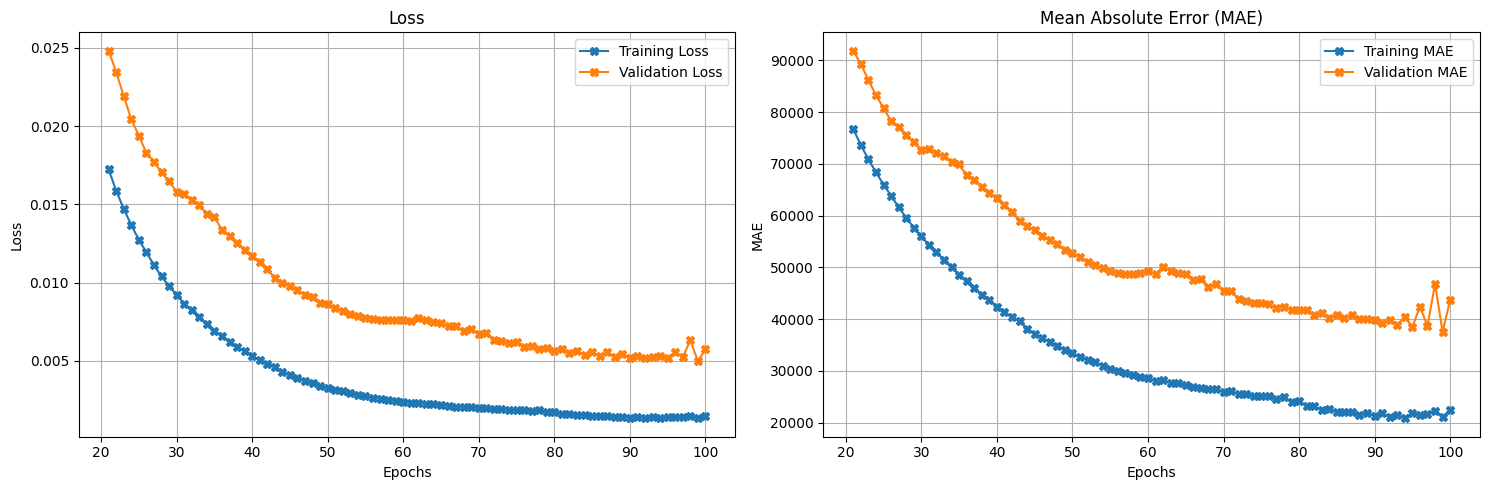

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
mae: 43709.17165706466
rmse: 57240.1174875633


In [ ]:
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mse", metrics=["mae"])

# history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_test, y_test))

# plot_for_model(history)

mae, rmse, history = train_nn_models(nn_model, 0, True, 1)

print(f"mae: {mae * max_y}")
print(f"rmse: {rmse * max_y}")

In [ ]:
nn_predictions = nn_model.predict(X_test)

nn_predictions = nn_predictions.flatten()

# y_test.head()
# nn_predictions[:5]



nn_mae = mean_absolute_error(y_test, nn_predictions)
nn_rmse = root_mean_squared_error(y_test, nn_predictions)

print(f"nn_mae: {nn_mae * max_y}")
print(f"nn_rmse: {nn_rmse * max_y}")

# print(f"nn_mae: {nn_mae}")
# print(f"nn_rmse: {nn_rmse}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
nn_mae: 46647.80651757307
nn_rmse: 64587.88991415946


In [ ]:
best_corr_threshold = best_lr = best_n_dense = best_n_units = None
best_mae = best_rmse = None
for corr_threshold in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    for lr in [0.001, 0.01, 0.1]:
        for n_dense in [1, 2, 3]:
            for n_units in [16, 32, 64]:
                print(f"corr_threshold: {corr_threshold}, learning_rate: {lr}, n_dense: {n_dense}, n_units: {n_units}")
                print()
                layers = []
                if n_dense > 0:
                    layers.append(tf.keras.layers.Dense(n_units, activation='relu'))
                if n_dense > 1:
                    layers.append(tf.keras.layers.Dense(n_units, activation='relu'))
                if n_dense > 2:
                    layers.append(tf.keras.layers.Dense(n_units, activation='relu'))
                layers.append(tf.keras.layers.Dense(1)),
                nn_model = tf.keras.models.Sequential(layers)
                nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="mse", metrics=["mae"])
                mae, rmse, history = train_nn_models(nn_model, corr_threshold, False, 0)

                if best_mae is None or mae < best_mae:
                    best_mae = mae
                    best_rmse = rmse
                    best_corr_threshold = corr_threshold
                    best_lr = lr
                    best_n_dense = n_dense
                    best_n_units = n_units

                    plot_for_model(history)

                    print(f"best_mae: {best_mae * max_y}")
                    print(f"best_rmse: {best_rmse * max_y}")
                print()

print(f"best_mae: {best_mae * max_y}")
print(f"best_rmse: {best_rmse * max_y}")
print(f"best_corr_threshold: {best_corr_threshold}")
print(f"best_lr: {best_lr}")
print(f"best_n_dense: {best_n_dense}")
print(f"best_n_units: {best_n_units}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

corr_threshold: 0.3, learning_rate: 0.001, n_dense: 3, n_units: 32

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

corr_threshold: 0.3, learning_rate: 0.001, n_dense: 3, n_units: 64

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

corr_threshold: 0.3, learning_rate: 0.01, n_dense: 1, n_units: 16

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

corr_threshold: 0.3, learning_rate: 0.01, n_dense: 1, n_units: 32

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

corr_threshold: 0.3, learning_rate: 0.01, n_dense: 1, n_units: 64

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

corr_threshold: 0.3, learning_rate: 0.01, n_dense: 2, n_units: 16

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

corr_threshold: 0.3, learning_rate: 0.01, n_dense: 2, n_units: 32

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

corr_threshold: 0.3, learning_rate: 0.01, n_dense: 2, n_units: 64

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

corr_threshold: 0.3, learning_rate: 0.01, n_dense: 3, n_units: 16

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6

best_mae: **17946.067443211603**

best_rmse: **27261.704407072448**

best_corr_threshold: **0.1**

best_lr: **0.01**

best_n_dense: **3**

best_n_units: **32**

In [ ]:
nn_model1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(51, )),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model1.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.Huber(), metrics=["mae"])

mae, rmse, history = train_nn_models(nn_model1, 0.1, True)

print(f"mae: {mae * max_y}")
print(f"rmse: {rmse * max_y}")

51


NameError: name 'plot_for_model' is not defined

**With Neural Networks it was really Unstable**




In [ ]:
# let's try to stabilize it

from tensorflow.keras.callbacks import EarlyStopping


nn_model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(51, )),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model2.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss="mse", metrics=["mae"])

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

df_modified = get_modified_df(0.1)
X_data, Y_data = prepare_labelized_data(df_modified, "SalePrice")
Y_data = scale_target(Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

history2 = nn_model2.fit(
    X_train, y_train,
    epochs=100,
    batch_size=12,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[earlyStopping]
)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1196 - mae: 0.2030 - val_loss: 0.0654 - val_mae: 0.2140
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - mae: 0.0677 - val_loss: 0.0170 - val_mae: 0.1047
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - mae: 0.0562 - val_loss: 0.0079 - val_mae: 0.0702
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - mae: 0.0501 - val_loss: 0.0059 - val_mae: 0.0595
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - mae: 0.0487 - val_loss: 0.0056 - val_mae: 0.0565
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - mae: 0.0432 - val_loss: 0.0050 - val_mae: 0.0537
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0407 - val_loss: 0.0037 - val_mae: 0.0465
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0403 - val_loss: 0.0052 - val_mae: 0.0569
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.002

In [ ]:
predictions = nn_model2.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)

print(mae, rmse)

print(f"mae: {mae * max_y}")
print(f"rmse: {rmse * max_y}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
0.038271574772139924 0.052715938346691436
mae: 28895.038952965642
rmse: 39800.53345175203


In [ ]:
test_data = prepare_test_dataset(0.1)

test_predictions = nn_model2.predict(test_data) * max_y

prepare_and_download_submission_file(test_predictions)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# Other's Model 1

In [ ]:
TRAIN_DATA_FILE = "/content/train.csv"
TEST_DATA_FILE = "/content/test.csv"

In [ ]:
import pandas as pd

data = pd.read_csv(TRAIN_DATA_FILE)

data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
target_column = data['SalePrice']

In [ ]:
missing_values = data.isnull().sum().sort_values(ascending=False)
missing_columns = missing_values[missing_values > 0]
missing_columns

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81


In [ ]:
missing_threshold = 0.8

columns_to_drop = missing_columns[missing_columns / len(data) > missing_threshold]

data = data.drop(columns=columns_to_drop.index, axis=1, errors='ignore')

In [ ]:
numerical = data.select_dtypes(include=['int64', 'float64'])
numerical_cols = numerical.columns

categorical = data.select_dtypes(include=['object'])
categorical_cols = categorical.columns

In [ ]:
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])

In [ ]:
missing_values = data.isnull().sum().sort_values(ascending=False)
missing_columns = missing_values[missing_values > 0]
missing_columns

,0


In [ ]:
correlation = numerical.corr()

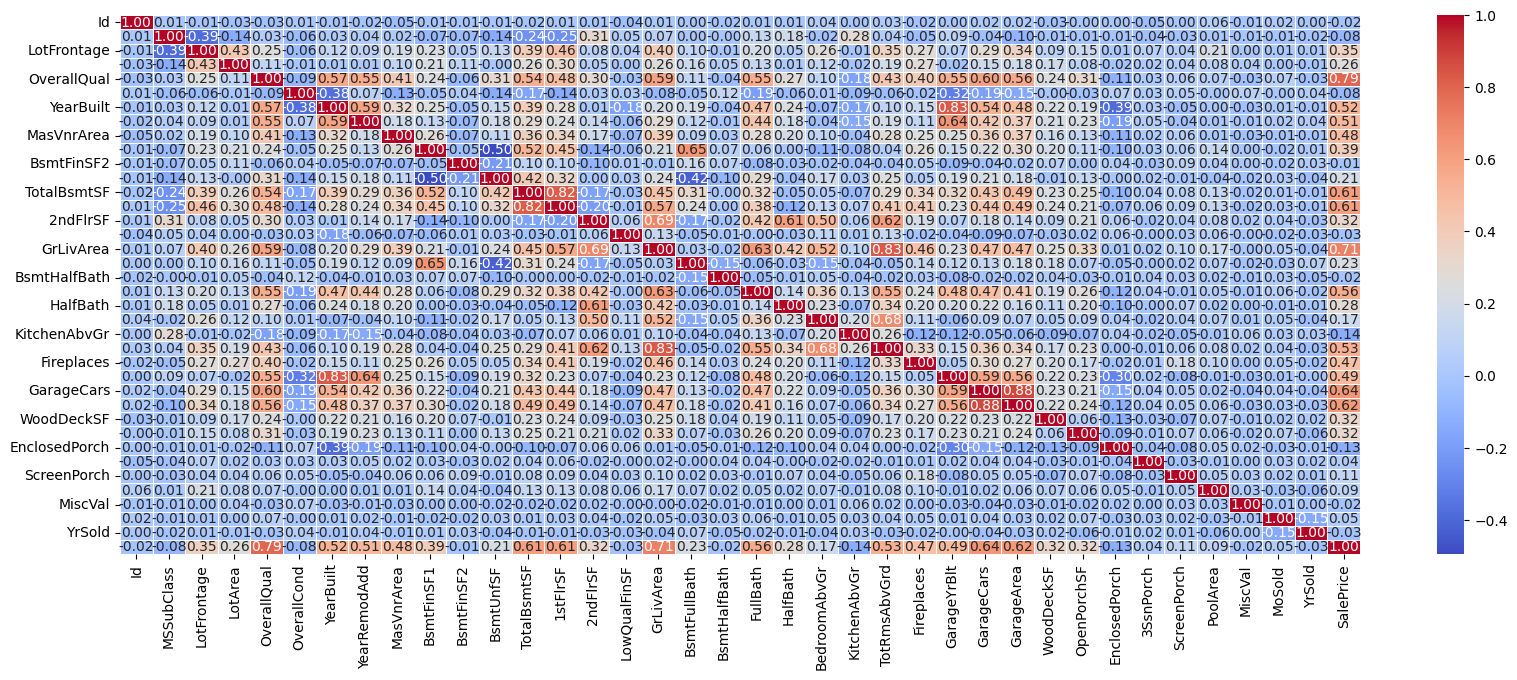

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 7))

sns.heatmap(
    correlation,
    annot=True, # to display corr values in heatmap
    cmap='coolwarm', # represents color to display heatmap
    fmt='.2f', # represents floating point to consider the values. example (.20, .23, .34)
    linewidths=0.5
)

plt.show()

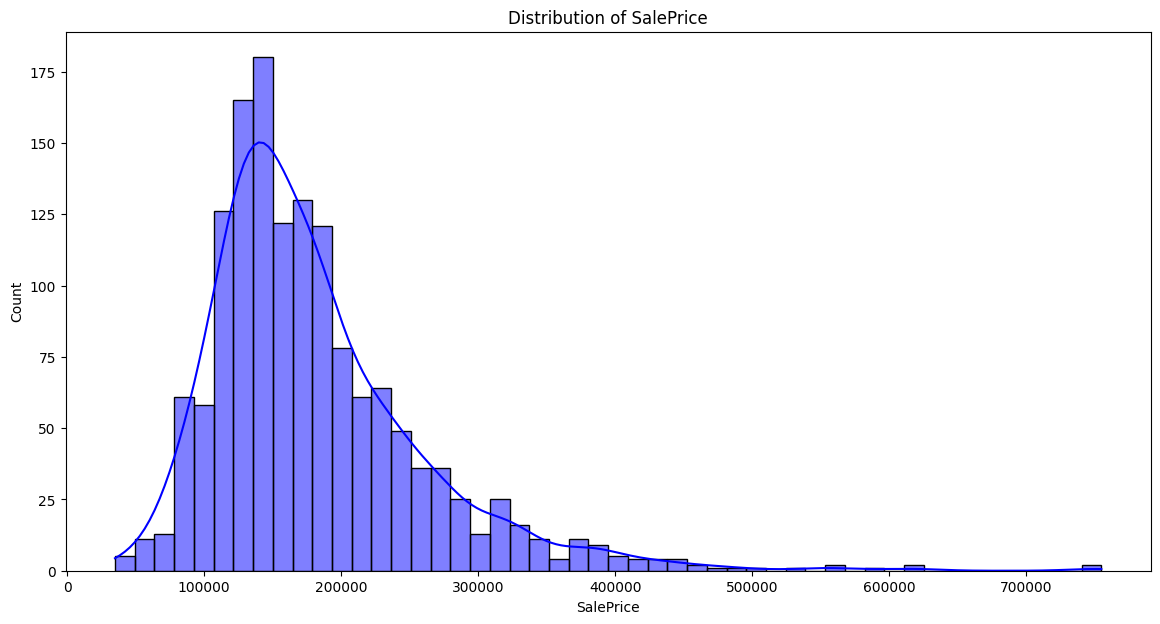

In [ ]:
plt.figure(figsize=(14, 7))

sns.histplot(
    data['SalePrice'],
    kde=True, # adds a smoother version of this curve. kde -->  Kernel Density Estimate
    color='blue',
    bins=50
)

plt.title('Distribution of SalePrice')

plt.show()

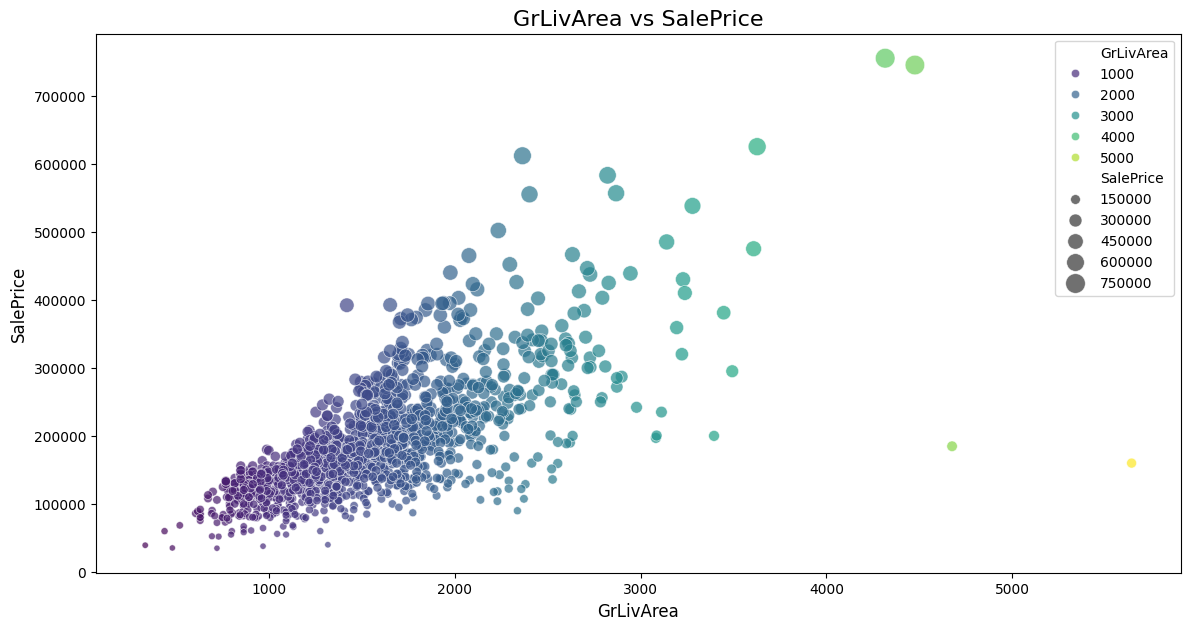

In [ ]:
plt.figure(figsize=(14, 7))

sns.scatterplot(
    data=data,
    x='GrLivArea',
    y=target_column,
    hue='GrLivArea',
    palette='viridis',
    alpha=0.7,
    size='SalePrice',
    sizes=(20, 200)
)

plt.title('GrLivArea vs SalePrice', fontsize=16)

plt.xlabel('GrLivArea', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)

plt.show()

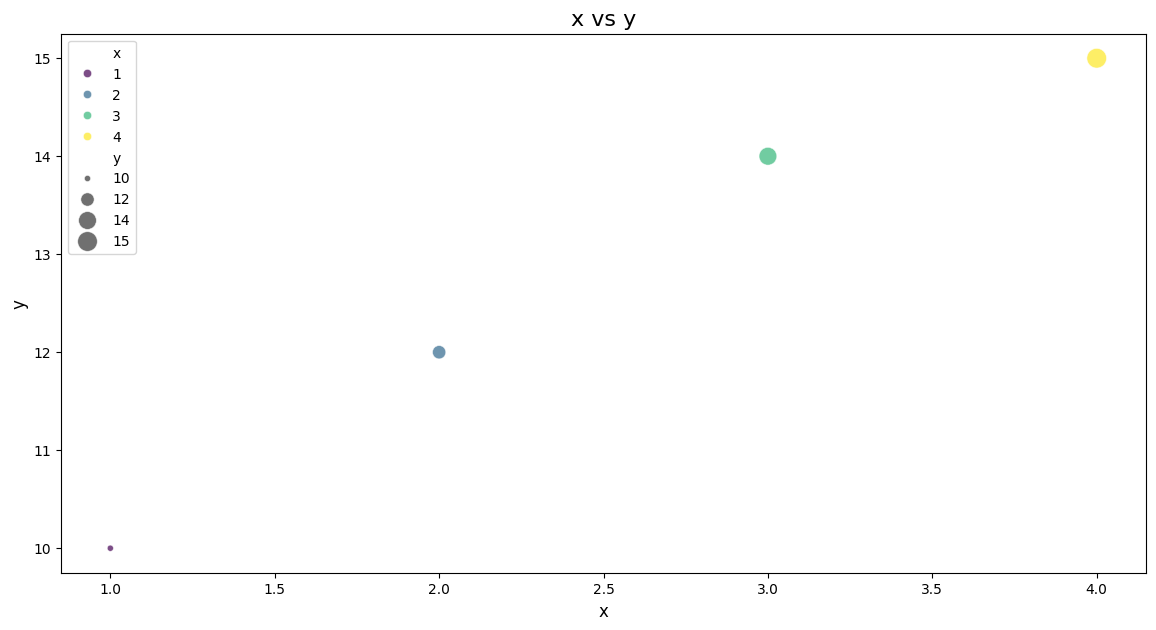

In [ ]:
# Understanding ScatterPlot

plt.figure(figsize=(14, 7))


sample_data = {'x': [1, 2, 3, 4],
        'y': [10, 12, 14, 15]}

# Create the DataFrame
df = pd.DataFrame(sample_data)

sns.scatterplot(
    data=df,
    x='x',
    y='y',
    hue='x',
    palette='viridis',
    alpha=0.7,
    size='y',
    sizes=(20, 200)
)

plt.title('x vs y', fontsize=16)

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)

plt.show()

In [ ]:
# Handling outliers

import numpy as np

for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])

In [ ]:
columns_to_drop = ['Id',
                   'MiscVal',
                   'MoSold',
                   'YrSold',
                   'LowQualFinSF',
                   'BsmtHalfBath',
                   '3SsnPorch']

data = data.drop(columns=columns_to_drop)

In [ ]:
for col in data.columns:
    unique_count = data[col].nunique()
    print(f"column: {col} = {unique_count}")

column: MSSubClass = 13
column: MSZoning = 5
column: LotFrontage = 78
column: LotArea = 1007
column: Street = 2
column: LotShape = 4
column: LandContour = 4
column: Utilities = 2
column: LotConfig = 5
column: LandSlope = 3
column: Neighborhood = 25
column: Condition1 = 9
column: Condition2 = 8
column: BldgType = 5
column: HouseStyle = 8
column: OverallQual = 9
column: OverallCond = 6
column: YearBuilt = 108
column: YearRemodAdd = 61
column: RoofStyle = 6
column: RoofMatl = 8
column: Exterior1st = 15
column: Exterior2nd = 16
column: MasVnrType = 3
column: MasVnrArea = 244
column: ExterQual = 4
column: ExterCond = 5
column: Foundation = 6
column: BsmtQual = 4
column: BsmtCond = 4
column: BsmtExposure = 4
column: BsmtFinType1 = 6
column: BsmtFinSF1 = 631
column: BsmtFinType2 = 6
column: BsmtFinSF2 = 1
column: BsmtUnfSF = 755
column: TotalBsmtSF = 699
column: Heating = 6
column: HeatingQC = 5
column: CentralAir = 2
column: Electrical = 5
column: 1stFlrSF = 734
column: 2ndFlrSF = 416
column

In [ ]:
single_value_columns = [col for col in data.columns if data[col].nunique() == 1]

print(f"Single Value Columns: {single_value_columns}")

Single Value Columns: ['BsmtFinSF2', 'KitchenAbvGr', 'EnclosedPorch', 'ScreenPorch', 'PoolArea']


In [ ]:
print("BsmtFinSF2 value counts:")
print(data['BsmtFinSF2'].value_counts())

print("\nKitchenAbvGr value counts:")
print(data['KitchenAbvGr'].value_counts())

print("\nEnclosedPorch value counts:")
print(data['EnclosedPorch'].value_counts())

print("\nScreenPorch value counts:")
print(data['ScreenPorch'].value_counts())

print("\nPoolArea value counts:")
print(data['PoolArea'].value_counts())

BsmtFinSF2 value counts:
BsmtFinSF2
0.0    1460
Name: count, dtype: int64

KitchenAbvGr value counts:
KitchenAbvGr
1.0    1460
Name: count, dtype: int64

EnclosedPorch value counts:
EnclosedPorch
0.0    1460
Name: count, dtype: int64

ScreenPorch value counts:
ScreenPorch
0.0    1460
Name: count, dtype: int64

PoolArea value counts:
PoolArea
0.0    1460
Name: count, dtype: int64


In [ ]:
data = data.drop(columns=single_value_columns, axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()



for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data_scaled = scaler.fit_transform(data)

data = pd.DataFrame(data_scaled, columns=data.columns)

In [ ]:
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='linear')
])

my_optimizer = tf.keras.optimizers.Adam(0.01)

model.compile(optimizer=my_optimizer, loss="mse", metrics=["mae"])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=12,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6347 - mae: 0.5998 - val_loss: 0.1856 - val_mae: 0.2897
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2010 - mae: 0.3409 - val_loss: 0.1112 - val_mae: 0.2317
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2120 - mae: 0.3450 - val_loss: 0.1183 - val_mae: 0.2361
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1674 - mae: 0.3162 - val_loss: 0.1544 - val_mae: 0.2851
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1968 - mae: 0.3398 - val_loss: 0.1083 - val_mae: 0.2278
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1975 - mae: 0.3391 - val_loss: 0.0960 - val_mae: 0.2228
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1758 - mae: 0.3220 - val_loss: 0.1046 - val_mae: 0.2294
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1640 - mae: 0.3115 - val_loss: 0.1128 - val_mae: 0.2405
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.169

In [ ]:
y_predict = model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_predict)

r2

0.9087767193566196

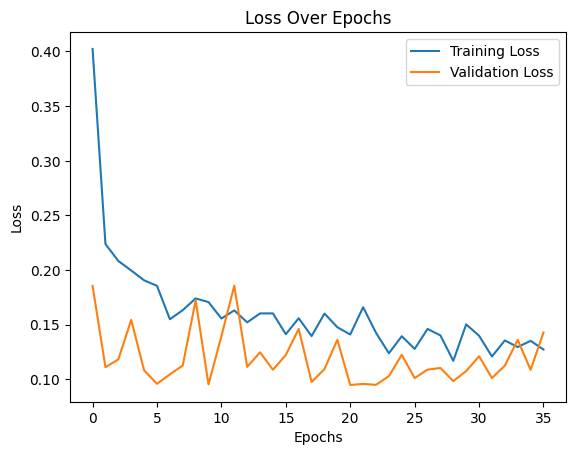

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(history.history['loss'] , label ='Training Loss')
plt.plot(history.history['val_loss'] , label ='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

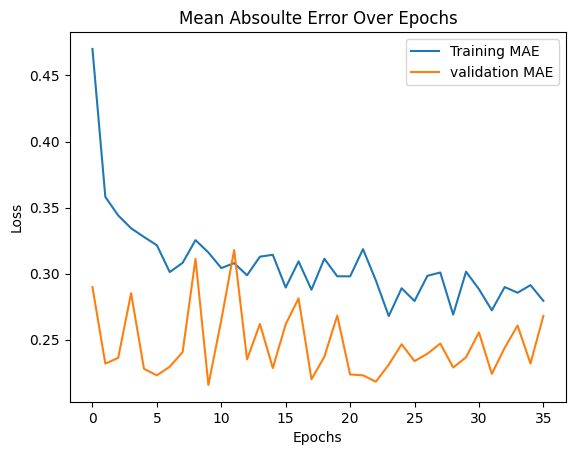

In [ ]:
plt.plot(history.history['mae'] , label ='Training MAE')
plt.plot(history.history['val_mae'] , label ='validation MAE')
plt.legend()
plt.title('Mean Absoulte Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Test Data Preprocessing

In [ ]:
data_test = pd.read_csv(TEST_DATA_FILE)

data_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
missing_values = data_test.isnull().sum().sort_values(ascending=False)
missing_columns = missing_values[missing_values > 0]
missing_columns

,0
PoolQC,1456
MiscFeature,1408
Alley,1352
Fence,1169
MasVnrType,894
FireplaceQu,730
LotFrontage,227
GarageYrBlt,78
GarageQual,78
GarageFinish,78


In [ ]:
missing_threshold = 0.8

columns_to_drop = missing_columns[missing_columns / len(data_test) > missing_threshold]

data_test = data_test.drop(columns=columns_to_drop.index, axis=1, errors="ignore")

In [ ]:
numerical = data_test.select_dtypes(include=['int64', 'float64'])
numerical_cols = numerical.columns

categorical = data_test.select_dtypes(include=['object'])
categorical_cols = categorical.columns

In [ ]:
data_test[numerical_cols] = data_test[numerical_cols].fillna(data_test[numerical_cols].median())
data_test[categorical_cols] = data_test[categorical_cols].fillna(data_test[categorical_cols].mode().iloc[0])

In [ ]:
missing_valuse = data_test.isnull().sum().sort_values(ascending=False)
missing_columns = missing_valuse[missing_valuse > 0]
missing_columns

,0


In [ ]:
columns_to_drop = ['Id',
                   'MiscVal',
                   'MoSold',
                   'YrSold',
                   'LowQualFinSF',
                   'BsmtHalfBath',
                   '3SsnPorch',
                   'BsmtFinSF2',
                   'KitchenAbvGr',
                   'EnclosedPorch',
                   'ScreenPorch',
                   'PoolArea']

data_test = data_test.drop(columns=columns_to_drop, axis=1, errors="ignore")

In [ ]:
for column in categorical_cols:
    data_test[column] = label_encoder.fit_transform(data_test[column])

In [ ]:
data_test_scaled = scaler.fit_transform(data_test)

data_test = pd.DataFrame(data_test_scaled, columns=data_test.columns)

In [ ]:
data_test.shape

(1459, 64)

In [ ]:
y_pred = model.predict(data_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
scal = StandardScaler()
Target_column = scal.fit_transform(target_column.values.reshape(-1, 1))
y_pred = scal.inverse_transform(y_pred)

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [ ]:
y_pred = y_pred.flatten()
y_pred

array([108153.234, 169961.73 , 183045.42 , ..., 169080.33 , 111922.74 ,
       233086.31 ], dtype=float32)

In [ ]:
submission['SalePrice'] = y_pred

submission.head()

,Id,SalePrice
0,1461,108153.234375
1,1462,169961.734375
2,1463,183045.421875
3,1464,198692.843750
4,1465,195963.078125


In [ ]:
prepare_and_download_submission_file(y_pred)